In [1]:
from feature_selector import *

import pandas as pd
import numpy as np
import seaborn as sns

from scipy.spatial import distance
from scipy.cluster import hierarchy

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

         apol       ASA      ASA+      ASA-     ASA_H     ASA_P    a_acc   
0    0.039739  0.052654  0.051855  0.044585  0.048074  0.048610  0.05698  \
1    0.076320  0.075341  0.000000  0.150000  0.000000  0.231884  0.00000   
2    0.053171  0.076801  0.015419  0.134993  0.000000  0.236377  0.05698   
3    0.067034  0.081523  0.109528  0.035056  0.058578  0.112676  0.05698   
4    0.014515  0.030469  0.028113  0.027999  0.026754  0.030642  0.02849   
..        ...       ...       ...       ...       ...       ...      ...   
141  0.064770  0.078362  0.028776  0.122582  0.102203  0.000000  0.00000   
142  0.062131  0.075601  0.031786  0.113588  0.098601  0.000000  0.00000   
143  0.064770  0.077528  0.028777  0.120921  0.101115  0.000000  0.00000   
144  0.059492  0.072341  0.034204  0.104288  0.094350  0.000000  0.00000   
145  0.063372  0.074162  0.021167  0.119882  0.094987  0.004104  0.00000   

     a_acid     a_aro    a_base  ...  vsurf_Wp4  vsurf_Wp5  vsurf_Wp6   
0       0.0  0

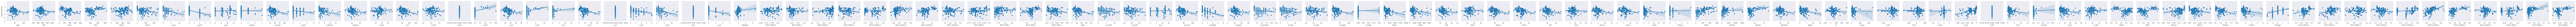

In [20]:
df_ionizable_train: pd.DataFrame = pd.read_csv("../../Data/ionizable_dataset_72_train_divprio.csv", delimiter=';')
df_ionizable_test: pd.DataFrame = pd.read_csv("../../Data/ionizable_dataset_72_test_divprio.csv", delimiter=';')


FS_io_train: FeatureSelector = FeatureSelector(df_ionizable_train)
FS_io_test: FeatureSelector = FeatureSelector(df_ionizable_train)

FS_io_train.scale_data(inplace=True)
FS_io_test.scale_data(inplace=True)


df_neutral_train: pd.DataFrame = pd.read_csv("../../Data/neutral_dataset_111_train_divprio.csv", delimiter=';')
df_neutral_test: pd.DataFrame = pd.read_csv("../../Data/neutral_dataset_111_test_divprio.csv", delimiter=';')

FS_ne_train: FeatureSelector = FeatureSelector(df_neutral_train)
FS_ne_test: FeatureSelector = FeatureSelector(df_neutral_test)

FS_ne_train.scale_data(inplace=True)
FS_ne_test.scale_data(inplace=True)

df_full_train: pd.DataFrame = pd.read_csv("../../Data/full_dataset_train_divprio.csv", delimiter=';')
df_full_test: pd.DataFrame = pd.read_csv("../../Data/full_dataset_test_divprio.csv", delimiter=';')


FS_full_train: FeatureSelector = FeatureSelector(df_full_train)
FS_full_test: FeatureSelector = FeatureSelector(df_full_test)

FS_full_train.scale_data(inplace=True)
print(FS_full_train.df)
FS_full_test.scale_data(inplace=True)


df_all =  [df_ionizable_train, df_ionizable_test, df_neutral_train, df_neutral_test, df_full_train, df_full_test]

#
# f, ax = plt.subplots(figsize=(12,10))
# fig = sns.pairplot(df_full_train, kind="reg", , ax=ax)



g = sns.pairplot(df_full_train, y_vars=["Log_MP_RATIO"],  x_vars=df_full_train.columns[1:100])
# g.map_diag(sns.histplot())
g.map_offdiag(sns.regplot)

# Low variance features
We try to detect every feature that has a variance below the threshold

## IONIZABLE

In [ ]:
FS_io_train.df.loc[:, FS_io_train.df.columns != "Log_MP_RATIO"].var(axis=1).mean() * 0.1

In [ ]:
print("===== TRAIN =====")
df_ionizable_train_lv, col_ionizable_train_lv = FS_io_train.remove_low_variance(variance_threshold=0.05)
print("===== TEST =====")
df_ionizable_test_lv, col_ionizable_test_lv = FS_io_test.remove_low_variance(variance_threshold=0.05)



col_ionizable_lv: set = set(col_ionizable_train_lv) & set(col_ionizable_test_lv)
print(col_ionizable_lv)
print("length of the feature with low variance that are common for train and test: ", len(col_ionizable_lv))



df_ionizable_train = df_ionizable_train.drop(list(col_ionizable_lv), axis=1)
df_ionizable_test = df_ionizable_test.drop(list(col_ionizable_lv), axis=1)

## NEUTRAL

In [ ]:
print("===== TRAIN =====")
df_neutral_train_lv, col_neutral_train_lv =FS_ne_train.remove_low_variance(variance_threshold=0.05)
print("===== TEST =====")
df_neutral_test_lv, col_neutral_test_lv = FS_ne_test.remove_low_variance(variance_threshold=0.05)

col_neutral_lv: set = set(col_neutral_train_lv) & set(col_neutral_test_lv)
print(col_neutral_lv)
print("length of the feature that are common for train and test: ", len(col_neutral_lv))

df_neutral_train = df_neutral_train.drop(list(col_neutral_lv), axis=1)
df_neutral_test = df_neutral_test.drop(list(col_neutral_lv), axis=1)

## FULL

In [ ]:
print("===== TRAIN =====")
df_full_train_lv, col_full_train_lv = FS_full_train.remove_low_variance(variance_threshold=0.05)
print("===== TEST =====")
df_full_test_lv, col_full_test_lv = FS_full_test.remove_low_variance(variance_threshold=0.05)

col_full_lv: set = set(col_full_train_lv) & set(col_full_test_lv)
print(col_full_lv)
print("length of the feature that are common for train and test: ", len(col_full_lv))

df_full_train = df_full_train.drop(list(col_full_lv), axis=1)
df_full_test = df_full_test.drop(list(col_full_lv), axis=1)

# High correlation feature

## IONIZABLE

In [ ]:
df_io_train_correlation: pd.DataFrame = FS_io_train.get_correlation(df_ionizable_train_lv)
df_io_train_correlation_removed = FS_io_train.remove_highly_correlated(df_io_train_correlation, df_ionizable_train_lv, threshold=0.9)

df_io_test_correlation: pd.DataFrame = FS_io_test.get_correlation(df_ionizable_test_lv)
df_io_test_correlation_removed = FS_io_test.remove_highly_correlated(df_io_test_correlation, df_ionizable_test_lv, threshold=0.9)

In [ ]:
# df_full_train_lv.loc[:,"vsurf_Wp8"]

df_io_train_removed_feat =  df_ionizable_train_lv.columns.difference(df_io_train_correlation_removed.columns)
df_io_test_removed_feat =  df_ionizable_test_lv.columns.difference(df_io_test_correlation_removed.columns)
io_feat_corr = list(set(df_io_train_removed_feat).intersection(df_io_test_removed_feat))
print("Number of features with strong correlations: ", len(io_feat_corr))

# Calcul de la matrice de distance (inverse de la matrice de correlation)
df_display = 1 - df_io_train_correlation.loc[io_feat_corr, io_feat_corr]
linkage = hierarchy.linkage(distance.squareform(df_display), method="average")
g = sns.clustermap(df_display, row_linkage=linkage, col_linkage=linkage)

mask = np.tril(np.ones_like(df_display))
values = g.ax_heatmap.collections[0].get_array().reshape(df_display.shape)
new_values = np.ma.array(values, mask=mask)
g.ax_heatmap.collections[0].set_array(new_values)

plt.show()

## Neutral

In [ ]:
df_ne_train_correlation: pd.DataFrame = FS_ne_train.get_correlation(df_neutral_train_lv)
df_ne_train_correlation_removed: pd.DataFrame = FS_ne_train.remove_highly_correlated(df_ne_train_correlation, df_neutral_train_lv, threshold=0.9)

df_ne_test_correlation: pd.DataFrame = FS_ne_test.get_correlation(df_neutral_test_lv)
df_ne_test_correlation_removed: pd.DataFrame = FS_ne_test.remove_highly_correlated(df_ne_test_correlation, df_neutral_test_lv, threshold=0.9)

In [ ]:
df_io_train_removed_feat =  df_ionizable_train_lv.columns.difference(df_io_train_correlation_removed.columns)
df_io_test_removed_feat =  df_ionizable_test_lv.columns.difference(df_io_test_correlation_removed.columns)
io_feat_corr = list(set(df_io_train_removed_feat).intersection(df_io_test_removed_feat))
print("Number of features with strong correlations: ", len(io_feat_corr))

# Calcul de la matrice de distance (inverse de la matrice de correlation)
df_display = 1 - df_io_train_correlation.loc[io_feat_corr, io_feat_corr]
linkage = hierarchy.linkage(distance.squareform(df_display), method="average")
g = sns.clustermap(df_display, row_linkage=linkage, col_linkage=linkage)

mask = np.tril(np.ones_like(df_display))
values = g.ax_heatmap.collections[0].get_array().reshape(df_display.shape)
new_values = np.ma.array(values, mask=mask)
g.ax_heatmap.collections[0].set_array(new_values)

plt.show()



df_ne_removed_feat: pd.DataFrame = df_ne

## Cluster analysis

In [ ]:
import pandas as pd
from feature_selector import *

d = {"A": [1,2,3,4], "B": [2,5,6,7], "C": [3,6,8,9], "D":[4,7,9,10]}
df = pd.DataFrame(data=d, index=["A", "B", "C", "D"])
df

FS = FeatureSelector(df)
FS.remove_highly_correlated(df)